### Źródła:
<a href="https://www.kaggle.com/datasets/siddharthkumar25/malicious-and-benign-urls" target="_blank"> Malicious And Benign URLs  </a> <br/>
<a href="https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset" target="_blank"> Malicious URLs dataset  </a>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
urls = pd.read_csv('urldata.csv', index_col=0)
print(urls['label'].unique())
print(urls[urls['label']=='benign'])
print(urls[urls['label']=='malicious'])

# Label column is basically useless

['benign' 'malicious']
                                       url   label  result
0                   https://www.google.com  benign       0
1                  https://www.youtube.com  benign       0
2                 https://www.facebook.com  benign       0
3                    https://www.baidu.com  benign       0
4                https://www.wikipedia.org  benign       0
...                                    ...     ...     ...
345733    https://taekwondo.wisebytes.net/  benign       0
345734        https://www.steveconway.net/  benign       0
345735                https://www.tkd.net/  benign       0
345736     https://www.taekwondobible.com/  benign       0
345737  https://www.angelfire.com/mi2/540/  benign       0

[345738 rows x 3 columns]
                                                      url      label  result
345738                   http://atualizacaodedados.online  malicious       1
345739                     http://webmasteradmin.ukit.me/  malicious       1
345740     

In [3]:
urls.drop(['label'], axis=1, inplace=True)
urls.columns = ['url', 'malicious']
print(urls.head())

                         url  malicious
0     https://www.google.com          0
1    https://www.youtube.com          0
2   https://www.facebook.com          0
3      https://www.baidu.com          0
4  https://www.wikipedia.org          0


In [4]:
counted_values = urls[['malicious']].value_counts()
print(counted_values)

# malicious = 1
malicious_count = counted_values.to_numpy()[1]

# benign = 0
benign_count = counted_values.to_numpy()[0]

malicious_percentage = np.round(malicious_count/(malicious_count + benign_count), 2)
benign_percentage = 1 - malicious_percentage

malicious
0            345738
1            104438
dtype: int64


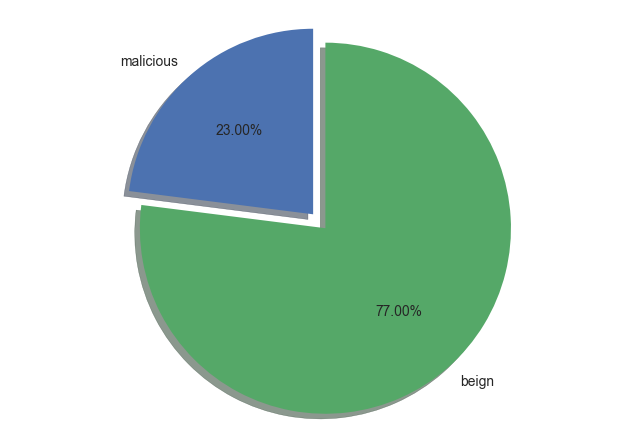

In [5]:
labels = ['malicious', 'beign']
sizes = [malicious_percentage, benign_percentage]
explode = (0.1, 0)

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%', shadow=True, startangle=90)
ax.axis('equal')

plt.show()
fig.savefig('malicious_ratio.jpg')

### Preprocessing

In [6]:
# Empty data
print('Empty data:', urls.isna().sum().sort_values())

Empty data: url          0
malicious    0
dtype: int64


In [7]:
# Duplicates
duplicates = urls.duplicated(subset=['url'], keep=False)
print('Duplicates: ', urls[duplicates])

Duplicates:  Empty DataFrame
Columns: [url, malicious]
Index: []


### Jak rozpoznać **wirusowe** linki?
https://www.du.edu/it/services/security/5-url-warning-signs

In [8]:
def is_https(s):
    return 1 if s[0:5] == 'https' else 0


print(is_https('https://'))
print(is_https('http://'))

1
0


In [9]:
urls['https'] = urls['url'].apply(is_https)
print(urls)

                                                      url  malicious  https
0                                  https://www.google.com          0      1
1                                 https://www.youtube.com          0      1
2                                https://www.facebook.com          0      1
3                                   https://www.baidu.com          0      1
4                               https://www.wikipedia.org          0      1
...                                                   ...        ...    ...
450171        http://ecct-it.com/docmmmnn/aptgd/index.php          1      0
450172  http://faboleena.com/js/infortis/jquery/plugin...          1      0
450173  http://faboleena.com/js/infortis/jquery/plugin...          1      0
450174                             http://atualizapj.com/          1      0
450175  http://writeassociate.com/test/Portal/inicio/I...          1      0

[450176 rows x 3 columns]


In [10]:
value_counts = urls[['https', 'malicious']].value_counts()
print(value_counts)
httpS_beign = value_counts.to_numpy()[0]
httpS_malicious = value_counts.to_numpy()[2]
http_beign = value_counts.to_numpy()[3]
http_malicious = value_counts.to_numpy()[1]

rows_count = httpS_beign + httpS_malicious + http_beign + http_malicious

httpS_beign_percentage = httpS_beign/rows_count
httpS_malicious_percentage = httpS_malicious/rows_count
http_beign_percentage = http_beign/rows_count
http_malicious_percentage = http_malicious/rows_count

https  malicious
1      0            345737
0      1             97955
1      1              6483
0      0                 1
dtype: int64


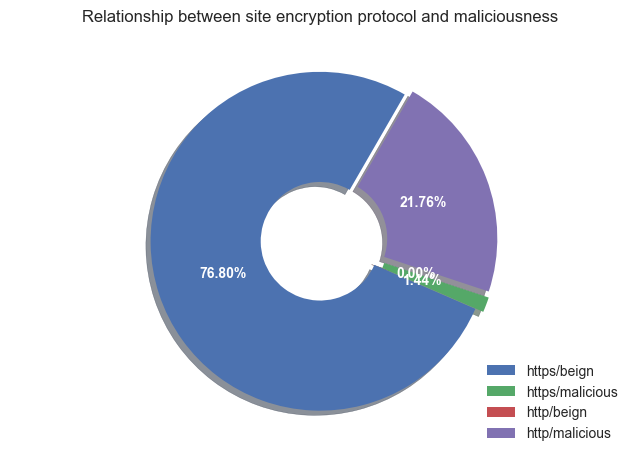

In [42]:
labels = ['https/beign', 'https/malicious', 'http/beign', 'http/malicious']
sizes = [httpS_beign_percentage, httpS_malicious_percentage, http_beign_percentage, http_malicious_percentage]
explode = (0, 0.05, 0, 0.05)

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots()
ax.axis('equal')

wedges, texts, autotexts = ax.pie(sizes, explode=explode, 
                                  wedgeprops=dict(width=0.65), autopct='%0.2f%%',
                                  shadow=True, startangle=60)

ax.legend(wedges, labels, loc="best")

plt.setp(autotexts, size=10, weight="bold", c='w', )



ax.set_title("Relationship between site encryption protocol and maliciousness")

plt.show()
fig.savefig('https_malicious_ratio.jpg')

In [13]:
X = urls[['https']].values
y = urls[['malicious']].values.ravel()

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

models = {
    'Decision Tree Classifier': DecisionTreeClassifier(),
    #'KNN': KNeighborsClassifier(n_neighbors=5),
    'LogisticRegression': LogisticRegression()
}

scores = []
for name, model in models.items():
    kf = KFold(n_splits=6, shuffle=True, random_state=5)
    cv_score = cross_val_score(model, X_train, y_train, cv=kf)
    scores.append(cv_score)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print('{}: {}'.format(name, accuracy))
    

(450176, 1) (450176,)
Decision Tree Classifier: 0.9851837042960594
LogisticRegression: 0.9851837042960594
